In [1]:
import h5py as h5
from math import sqrt,pi
import numpy as np
import matplotlib.pyplot as plt
from plot_settings import plotparams
from kinematic_functions import zed#qsq,k,wl
from BGL import phi#,blaschke
#from scipy.optimize import minimize_scalar
import time
import masses
from tqdm import tqdm
from numba import jit

In [2]:
import milc_bs2k as milc

In [3]:
#plt.rcParams.update(plotparams)

In [4]:
@jit(nopython=True)
def ggzprod(zi,zj):
    """
    inner product <g_s|g_t>
    """
    return 1.0/(1.0-zi*zj)

In [5]:
@jit(nopython=True)
def Gmatrix(zl):
    """
    G matrix for values of z in list zl
    """
    npts=len(zl)
    G=np.zeros((npts,npts))
    for i,zi in enumerate(zl):
        G[i,i]=ggzprod(zi,zi)
        for j in range(i+1,npts):
            G[i,j]=ggzprod(zi,zl[j])
            G[j,i]=G[i,j]
    return G

In [6]:
# light mesons
mpi=(2*0.13957061+0.1349770)/3 # PDG2018
mK=(0.493677+0.497611)/2       # PDG2018

# B mesons
mB=(5.27933+5.27964)/2
mBstar= 5.32470
mBs=5.36682
mBstar0plus=5.63

tp=(mBs+mK)**2
tm=(mBs-mK)**2 # = qsqmax
tcut=(mB+mpi)**2
t0=tcut-sqrt(tcut*(tcut-tm))# D mesons

etaBsK=1
chi1minusBsK=6.03e-4
chi0plusBsK=1.48e-2
fpluspoles=np.array([mBstar])
fzeropoles=np.array([])

zmax=zed(0,tcut,t0)

# z-values for pole positions
zpluspole=zed(mBstar**2,tcut,t0)
#zzeropole=zed(mBstar0plus**2,tcut,t0) # mBstar0plus is above threshold
#nplus=2 # number of input values for f+
#nzero=3 # number of input values for f0
#qsqmin='17.50' # (17.50,18.,00,18.50,19.00)
path=''


In [7]:
tcut

29.349570696829012

In [8]:
def compute_bounds(tl,fpinputs,fzinputs):
    """Compute dispersive bounds at a list of t = qsq values given input
        data on f+ and f0
        tl : one or a list of t values
        fpinputs = (tinl,fl,chi)
            tinl : t-values where form factor f+ is known
            fl : corresponind f+ form factor values
            chi : chi for f+
            zpole : pole location for f+
        fzinputs = (zl,fl,chi)
            zl : z-values where form factor f0 is known
            fl : corresponind f0 form factor values
            chi : chi for f0
            zpole : pole location for f0

        returns 1D array fp,dfp,fz,dfz if tl is a single value
        returns array of shape (nt,4) if tl has nt values
        returns np.array([0,0,0,0]) if unitarity check on inputs fails
    """
    tpin,fpin,chip,zppole=fpinputs
    tzin,fzin,chiz,zzpole=fzinputs
    zpin=zed(tpin,tcut,t0)
    zzin=zed(tzin,tcut,t0)

    #phifp=phi(tin,3,2,tcut,t0,tm,(eta,48.0*pi,1.0))*blaschke(tin,tcut,fpluspoles)*fpin
    #phifz=phi(tin,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*blaschke(tin,tcut,fzeropoles)*fzin
    # if only one pole for each form factor, calculate Blaschke factors more directly
    Fp=phi(tpin,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((zpin-zppole)/(1.0-zpin*zppole))*fpin
    #Fz=phi(tzin,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*((zzin-zzpole)/(1.0-zzin*zzpole))*fzin
    Fz=phi(tzin,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))*fzin

    dil=[np.prod((1.0-z*np.delete(zpin,i))/(z-np.delete(zpin,i))) for i,z in enumerate(zpin)]
    Fpdl=Fp*dil*(1.0-zpin**2)
    Gp=Gmatrix(zpin)
    chimchibarp=chip-np.dot(Fpdl,np.dot(Gp,Fpdl)) # should be positive
    if chimchibarp<0.0:
        #print('unitarity failed for f+ inputs: ',chimchibarp)
        return np.array([0,0,0,0])

    dil=[np.prod((1.0-z*np.delete(zzin,i))/(z-np.delete(zzin,i))) for i,z in enumerate(zzin)]
    Fzdl=Fz*dil*(1.0-zzin**2)
    Gz=Gmatrix(zzin)
    chimchibarz=chiz-np.dot(Fzdl,np.dot(Gz,Fzdl)) # should be positive
    if chimchibarz<0.0:
        #print('unitarity failed for f0 inputs: ',chimchibarz)
        return np.array([0,0,0,0])

    # start t- and z0-dependent stuff
    if type(tl)==float:
        tl=[tl]
    boundsl=np.zeros((len(tl),4))
    for i,t in enumerate(tl):
        z0=zed(t,tcut,t0)

        jot=1.0e-6
        dtl=np.abs(t-tpin)
        if np.min(dtl)<jot: # numerically avoid problems it t is one of the input t-values
            fp,dfp=fpin[np.argmin(dtl)],0.0
        else:
            d0=np.prod((1.0-z0*zpin)/(z0-zpin))
            phipt=phi(t,3,2,tcut,t0,tm,(etaBsK,48.0*pi,1.0))*((z0-zppole)/(1.0-z0*zppole))
            fp,dfp=(-np.dot(Fpdl,1.0/(zpin-z0))/d0,
                    sqrt(chimchibarp/(1-z0*z0))/abs(d0))/phipt

        dtl=np.abs(t-tzin)
        if np.min(dtl)<jot:
            fz,dfz=fzin[np.argmin(dtl)],0.0
        else:
            d0=np.prod((1.0-z0*zzin)/(z0-zzin))
            #phizt=phi(t,1,1,tcut,t0,tm,(eta,16.0*pi/(tp*tm),1.0))*((z0-zzpole)/(1.0-z0*zzpole))
            phizt=phi(t,1,1,tcut,t0,tm,(etaBsK,16.0*pi/(tp*tm),1.0))
            fz,dfz=(-np.dot(Fzdl,1.0/(zzin-z0))/d0,
                    sqrt(chimchibarz/(1-z0*z0))/abs(d0))/phizt

        boundsl[i]=fp,dfp,fz,dfz

    if boundsl.shape==(1,4):
        return boundsl[0]
    else:
        return boundsl

In [9]:
def ff_E(Evec,pole,coeff):
  # construct ff from HMChPT in continuum limit
  return [1./(E+pole)*np.sum([E**i*coeff[i] for i in range(len(coeff))]) for E in Evec]

In [10]:
def cov_ff_p0(Evec_p,Evec_0,C,Np,N0,pole_p,pole_0):
  # construct covariance matrix for ff from HMChPT in continuum limit
  Y_E_p_vec   	= lambda E_p: np.r_[ np.array([1./(E_p+pole_p)*E_p**i for i in range(Np)])]
  Y_E_0_vec   	= lambda E_0: np.r_[ np.array([1./(E_0+pole_0)*E_0**i for i in range(N0)])]
  Cpp		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np,:Np],Y_E_p_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_p])
  C00		= np.array([[np.dot(Y_E_0_vec(E1),np.dot(C[Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_0] for E2 in Evec_0])
  Cp0		= np.array([[np.dot(Y_E_p_vec(E1),np.dot(C[:Np:,Np:],Y_E_0_vec(E2)))
					for E1 in Evec_p] for E2 in Evec_0])
  M0		= np.r_['-1',Cpp  ,Cp0.T]
  M1		= np.r_['-1',Cp0  ,C00  ]
  M		= np.r_[M0,M1]
  return M

In [11]:
# define kinematics
mKphys		= masses.mK
mBsphys		= masses.mBs

In [12]:
def bounds_from_input_q2(plustlist,zerotlist,nboot=2000,toutl=np.linspace(0.0,tm,10)):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.array(plustlist + zerotlist)


    zinputl=zed(qsqinputl,tcut,t0)

    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))

    # input f+ and f0 values
    tpin=qsqinputl[:nplus]
    zpin=zed(tpin,tcut,t0)
    fpin=bskpts[:nplus]
    dfpin=dbsk[:nplus]
    tzin=qsqinputl[nplus:]
    zzin=zed(tzin,tcut,t0)
    fzin=bskpts[nplus:]
    dfzin=dbsk[nplus:]
    nppts=len(zpin)
    nzpts=len(zzin)

    # print('Inputs: first for f+ then f0')
    # with np.printoptions(precision=4,floatmode='fixed',
    #                       formatter={'float_kind':lambda x: '{:6.4f}'.format(x)}):
    #     print('t=q^2',tpin,tzin)
    #     print('z(t) ',zpin,zzin)
    #     print('f+/0 ',fpin,fzin)
    #     print('df+/0',dfpin,dfzin)
    # print('')




    fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    #print(fpinputs)
    #print(fzinputs)
    fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)
    # print('bounds at t = qsq = 0')
    # print('fplus_high {:11.9f},  fplus_low {:11.9f}'.format(fp+dfp,fp-dfp))
    # print('fzero_high {:11.9f},  fzero_low {:11.9f}'.format(fz+dfz,fz-dfz))
    # print('')



    # bootstrapping for f+(0) = f0(0)

    start=time.time()


    ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK


    bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
    bounds0indices=[] # keep list of indices of samples which give a bound
    nboottilde=0
    nbootstar=0
    for i,samp in enumerate(ffsamp):
        fpi=samp[:nplus]
        fzi=samp[nplus:]
        #chi1m=chi1minus
        #chi0p=chi0plus

        fpinputs=(tpin,fpi,chi1m,zpluspole)
        fzinputs=(tzin,fzi,chi0p,zpluspole)

        shark=compute_bounds(0.0,fpinputs,fzinputs)

        if shark.all()==False: # inputs don't satisfy unitarity
            pass
        else:
            nboottilde+=1
            fp,dfp,fz,dfz=shark
            if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
                pass
            else: # if pass both checks record f(0) bounds and sample index
                nbootstar+=1
                bounds0l.append((fp,dfp,fz,dfz))
                bounds0indices.append(i)

    # print('Nboot      = {:d} samples to generate f+(0) = f0(0)'.format(nboot))
    # print('Nboottilde = {:d} ({:.1f} %) passed unitarity check'.format(nboottilde,
    #                                                                     100.0*nboottilde/nboot))
    # print('Nbootstar  = {:d} ({:.1f} %) passed kinematic constraint'.format(nbootstar,
    #                                                                         100.0*nbootstar/nboot))
    # print('')



    # now do inner bootstrap on each of the nbootstar events

    # values of t = qsq where we want to evaluate bounds
    
    ntout=len(toutl)

    # for inner bootstrap
    n0=2
    # print('N0         = {:d} for inner bootstrap'.format(n0))
    # print('')

    results=np.zeros((ntout,4,nbootstar))
    #print("nbootstar = ",nbootstar)

    for i,bounds0 in enumerate(bounds0l):

        fp,dfp,fz,dfz=bounds0
        fpup,fplo,fzup,fzlo=fp+dfp,fp-dfp,fz+dfz,fz-dfz
        fstarup=min(fp+dfp,fz+dfz)
        fstarlo=max(fp-dfp,fz-dfz)
        index=bounds0indices[i]
        fpi=ffsamp[index,:nplus]
        fzi=ffsamp[index,nplus:]
        tpin_inner=np.concatenate(([0.0],tpin))
        tzin_inner=np.concatenate(([0.0],tzin))
        # sample uniformly
        #fstarsamp=np.random.uniform(fstarlo,fstarup,size=n0)
        # or use n0 equally-spaced values (n0=2 gives just the endpoints)
        jot=1.0e-9
        fstarsamp=np.linspace(fstarlo+jot,fstarup-jot,n0)
        boundsinner=np.zeros((n0,ntout,4))
        for j,fstar in enumerate(fstarsamp):
            fpinner=np.concatenate(([fstar],fpi))
            fzinner=np.concatenate(([fstar],fzi))
            fpinputs_inner=(tpin_inner,fpinner,chi1m,zpluspole)
            fzinputs_inner=(tzin_inner,fzinner,chi0p,zpluspole)

            boundsinner[j]=compute_bounds(toutl,fpinputs_inner,fzinputs_inner)

        fpbarup=np.max(boundsinner[:,:,0]+boundsinner[:,:,1],axis=0)
        fpbarlo=np.min(boundsinner[:,:,0]-boundsinner[:,:,1],axis=0)
        fzbarup=np.max(boundsinner[:,:,2]+boundsinner[:,:,3],axis=0)
        fzbarlo=np.min(boundsinner[:,:,2]-boundsinner[:,:,3],axis=0)
        results[:,0,i]=fpbarup
        results[:,1,i]=fpbarlo
        results[:,2,i]=fzbarup
        results[:,3,i]=fzbarlo

    stop=time.time()
    dt=stop-start
    # print('Time taken: {:d}m{:d}s'.format(int(dt//60),round(dt-60*(dt//60))))
    # print('')
    #print(results)
    #print(toutl)
    raven=results.mean(axis=2)
    fplus=(raven[:,0]+raven[:,1])/2
    fzero=(raven[:,2]+raven[:,3])/2
    fplusup,fpluslo=raven[:,0],raven[:,1]
    fzeroup,fzerolo=raven[:,2],raven[:,3]
    covplus=np.array([np.cov(arg[:2],ddof=1) for arg in results])
    covzero=np.array([np.cov(arg[2:],ddof=1) for arg in results])
    #print("covzero = ",covzero)
    sigplus=np.sqrt((fplusup-fpluslo)**2/12+(covplus[:,0,0]+covplus[:,1,1]+covplus[:,0,1])/3)
    sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
    #print('t        f+bds       f0bds')
    # for t,fp,fz,dfp,dfz in zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,
    #                            np.round(10000*sigplus),np.round(10000*sigzero)):
        #print('{:7.4f}  {:.4f}({:4.0f})  {:.4f}({:4.0f})'.format(t,fp,dfp,fz,dfz))
    return list(zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,sigplus,sigzero))



In [13]:
def bounds_from_input_q2_and_MILC(plustlist,zerotlist,milcq2list,nboot=2000,toutl=np.linspace(0.0,tm,10)):
    nplus = len(plustlist)
    nzero = len(zerotlist)
    #
    qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
    qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

    #
    ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
    ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

    ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
    ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
    Deltapar	= + 0.263
    Deltaperp	= - 0.0416


    f=h5.File('BstoK_ref_ff_dat.hdf5','r')
    cp_BstoK=np.array(f.get('cp'))
    c0_BstoK=np.array(f.get('c0'))
    Cp0_BstoK=np.array(f.get('Cp0'))
    fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
    f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
    ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
    Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

    bskpts = np.r_[fp_BstoK,f0_BstoK]
    bskcov = np.array(Cp0_ref)

    qsqinputl = np.array(plustlist + zerotlist)


    zinputl=zed(qsqinputl,tcut,t0)

    npts=len(bskpts)
    bskptslbls=[char for char in nplus*'+'+nzero*'0']

    dbsk=np.sqrt(bskcov.diagonal())
    bskcov=0.5*(bskcov + np.transpose(bskcov))

    # input f+ and f0 values
    tpin=qsqinputl[:nplus]
    zpin=zed(tpin,tcut,t0)
    fpin=bskpts[:nplus]
    dfpin=dbsk[:nplus]
    tzin=qsqinputl[nplus:]
    zzin=zed(tzin,tcut,t0)
    fzin=bskpts[nplus:]
    dfzin=dbsk[nplus:]
    nppts=len(zpin)
    nzpts=len(zzin)

    # print('Inputs: first for f+ then f0')
    # with np.printoptions(precision=4,floatmode='fixed',
    #                       formatter={'float_kind':lambda x: '{:6.4f}'.format(x)}):
    #     print('t=q^2',tpin,tzin)
    #     print('z(t) ',zpin,zzin)
    #     print('f+/0 ',fpin,fzin)
    #     print('df+/0',dfpin,dfzin)
    # print('')




    fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    #print(fpinputs)
    #print(fzinputs)
    fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)
    # print('bounds at t = qsq = 0')
    # print('fplus_high {:11.9f},  fplus_low {:11.9f}'.format(fp+dfp,fp-dfp))
    # print('fzero_high {:11.9f},  fzero_low {:11.9f}'.format(fz+dfz,fz-dfz))
    # print('')



    # bootstrapping for f+(0) = f0(0)

    start=time.time()


    ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
    milc_ffsamp = np.array(milc.resample_ff(milcq2list,nboot))
    print(np.shape(ffsamp))
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK


    bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
    bounds0indices=[] # keep list of indices of samples which give a bound
    nboottilde = 0
    nbootstar = 0
    for i in range(nboot):
        milc_samp = milc_ffsamp[:,:,i]
        samp = ffsamp[i]
        fpi=samp[:nplus]
        fzi=samp[nplus:]
        #chi1m=chi1minus
        #chi0p=chi0plus

        fpinputs=(np.append(tpin,milcq2list),np.append(fpi,milc_samp[1]),chi1m,zpluspole)
        fzinputs=(np.append(tzin,milcq2list),np.append(fzi,milc_samp[0]),chi0p,zpluspole)
#         nplus += len()
        
        #print(fpinputs)
        #print(fzinputs)
        shark=compute_bounds(0.0,fpinputs,fzinputs)

        if shark.all()==False: # inputs don't satisfy unitarity
            pass
        else:
            nboottilde+=1
            fp,dfp,fz,dfz=shark
            if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
                pass
            else: # if pass both checks record f(0) bounds and sample index
                nbootstar+=1
                bounds0l.append((fp,dfp,fz,dfz))
                bounds0indices.append(i)

    # print('Nboot      = {:d} samples to generate f+(0) = f0(0)'.format(nboot))
    print('Nboottilde = {:d} ({:.1f} %) passed unitarity check'.format(nboottilde,100.0*nboottilde/nboot))
    # print('Nbootstar  = {:d} ({:.1f} %) passed kinematic constraint'.format(nbootstar,
    #                                                                         100.0*nbootstar/nboot))
    # print('')



    # now do inner bootstrap on each of the nbootstar events

    # values of t = qsq where we want to evaluate bounds
    
    ntout=len(toutl)

    # for inner bootstrap
    n0=2
    # print('N0         = {:d} for inner bootstrap'.format(n0))
    # print('')

    results=np.zeros((ntout,4,nbootstar))
    for i,bounds0 in enumerate(bounds0l):

        fp,dfp,fz,dfz=bounds0
        fpup,fplo,fzup,fzlo=fp+dfp,fp-dfp,fz+dfz,fz-dfz
        fstarup=min(fp+dfp,fz+dfz)
        fstarlo=max(fp-dfp,fz-dfz)
        index=bounds0indices[i]
        fpi=ffsamp[index,:nplus]
        fzi=ffsamp[index,nplus:]
        print(fpi,fzi)
        tpin_inner=np.concatenate(([0.0],tpin))
        tzin_inner=np.concatenate(([0.0],tzin))
        # sample uniformly
        #fstarsamp=np.random.uniform(fstarlo,fstarup,size=n0)
        # or use n0 equally-spaced values (n0=2 gives just the endpoints)
        jot=1.0e-9
        fstarsamp=np.linspace(fstarlo+jot,fstarup-jot,n0)
        boundsinner=np.zeros((n0,ntout,4))
        for j,fstar in enumerate(fstarsamp):
            fpinner=np.concatenate(([fstar],fpi))
            fzinner=np.concatenate(([fstar],fzi))
            fpinputs_inner=(tpin_inner,fpinner,chi1m,zpluspole)
            fzinputs_inner=(tzin_inner,fzinner,chi0p,zpluspole)

            boundsinner[j]=compute_bounds(toutl,fpinputs_inner,fzinputs_inner)

        fpbarup=np.max(boundsinner[:,:,0]+boundsinner[:,:,1],axis=0)
        fpbarlo=np.min(boundsinner[:,:,0]-boundsinner[:,:,1],axis=0)
        fzbarup=np.max(boundsinner[:,:,2]+boundsinner[:,:,3],axis=0)
        fzbarlo=np.min(boundsinner[:,:,2]-boundsinner[:,:,3],axis=0)
        results[:,0,i]=fpbarup
        results[:,1,i]=fpbarlo
        results[:,2,i]=fzbarup
        results[:,3,i]=fzbarlo

    stop=time.time()
    dt=stop-start
    # print('Time taken: {:d}m{:d}s'.format(int(dt//60),round(dt-60*(dt//60))))
    # print('')

    #print(toutl)
    raven=results.mean(axis=2)
    fplus=(raven[:,0]+raven[:,1])/2
    fzero=(raven[:,2]+raven[:,3])/2
    fplusup,fpluslo=raven[:,0],raven[:,1]
    fzeroup,fzerolo=raven[:,2],raven[:,3]
    covplus=np.array([np.cov(arg[:2],ddof=1) for arg in results])
    covzero=np.array([np.cov(arg[2:],ddof=1) for arg in results])
    sigplus=np.sqrt((fplusup-fpluslo)**2/12+(covplus[:,0,0]+covplus[:,1,1]+covplus[:,0,1])/3)
    sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
    #print('t        f+bds       f0bds')
    # for t,fp,fz,dfp,dfz in zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,
    #                            np.round(10000*sigplus),np.round(10000*sigzero)):
        #print('{:7.4f}  {:.4f}({:4.0f})  {:.4f}({:4.0f})'.format(t,fp,dfp,fz,dfz))
    return list(zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,sigplus,sigzero))



In [14]:
def bounds_from_MILC(milcq2list,nboot=2000,toutl=np.linspace(0.0,tm,10)):
    nplus = len(milcq2list)
    nzero = len(milcq2list)
#     #
#     qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
#     qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

#     #
#     ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
#     ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

#     ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
#     ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
#     Deltapar	= + 0.263
#     Deltaperp	= - 0.0416


#     f=h5.File('BstoK_ref_ff_dat.hdf5','r')
#     cp_BstoK=np.array(f.get('cp'))
#     c0_BstoK=np.array(f.get('c0'))
#     Cp0_BstoK=np.array(f.get('Cp0'))
#     fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
#     f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
#     ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
#     Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

#     bskpts = np.r_[fp_BstoK,f0_BstoK]
#     bskcov = np.array(Cp0_ref)

#     qsqinputl = np.array(plustlist + zerotlist)


#     zinputl=zed(qsqinputl,tcut,t0)

#     npts=len(bskpts)
#     bskptslbls=[char for char in nplus*'+'+nzero*'0']

#     dbsk=np.sqrt(bskcov.diagonal())
#     bskcov=0.5*(bskcov + np.transpose(bskcov))

    # input f+ and f0 values
    tpin=milcq2list
#     zpin=zed(tpin,tcut,t0)
#     fpin=bskpts[:nplus]
#     dfpin=dbsk[:nplus]
    tzin=milcq2list
#     zzin=zed(tzin,tcut,t0)
#     fzin=bskpts[nplus:]
#     dfzin=dbsk[nplus:]
    #nppts=len(zpin)
    #nzpts=len(zzin)

    # print('Inputs: first for f+ then f0')
    # with np.printoptions(precision=4,floatmode='fixed',
    #                       formatter={'float_kind':lambda x: '{:6.4f}'.format(x)}):
    #     print('t=q^2',tpin,tzin)
    #     print('z(t) ',zpin,zzin)
    #     print('f+/0 ',fpin,fzin)
    #     print('df+/0',dfpin,dfzin)
    # print('')




    #fpinputs=(tpin,fpin,chi1minusBsK,zpluspole)
    #fzinputs=(tzin,fzin,chi0plusBsK,zpluspole) # !!! zpluspole just a dummy here
    #print(fpinputs)
    #print(fzinputs)
    #fp,dfp,fz,dfz=compute_bounds(0.0,fpinputs,fzinputs)
    # print('bounds at t = qsq = 0')
    # print('fplus_high {:11.9f},  fplus_low {:11.9f}'.format(fp+dfp,fp-dfp))
    # print('fzero_high {:11.9f},  fzero_low {:11.9f}'.format(fz+dfz,fz-dfz))
    # print('')



    # bootstrapping for f+(0) = f0(0)

    start=time.time()


    #ffsamp=np.random.multivariate_normal(bskpts,bskcov,size=nboot)
    milc_ffsamp = np.array(milc.resample_ff(milcq2list,nboot))
    #print(np.shape(milc_ffsamp))
    chi1m=chi1minusBsK
    chi0p=chi0plusBsK


    bounds0l=[] # to accumulate bounds for f+(0) = f0(0)
    bounds0indices=[] # keep list of indices of samples which give a bound
    nboottilde = 0
    nbootstar = 0
    for i in range(nboot):
        milc_samp = milc_ffsamp[:,:,i]
#         fpi=samp[:nplus]
#         fzi=samp[nplus:]
        #chi1m=chi1minus
        #chi0p=chi0plus

        fpinputs=(np.array(milcq2list),milc_samp[1],chi1m,zpluspole)
        fzinputs=(np.array(milcq2list),milc_samp[0],chi0p,zpluspole)
#         nplus += len()
        
        #print(fpinputs)
        #print(fzinputs)
        shark=compute_bounds(0.0,fpinputs,fzinputs)

        if shark.all()==False: # inputs don't satisfy unitarity
            pass
        else:
            nboottilde+=1
            fp,dfp,fz,dfz=shark
            if fp+dfp<=fz-dfz or fz+dfz<=fp-dfp:
                pass
            else: # if pass both checks record f(0) bounds and sample index
                nbootstar+=1
                bounds0l.append((fp,dfp,fz,dfz))
                bounds0indices.append(i)

    # print('Nboot      = {:d} samples to generate f+(0) = f0(0)'.format(nboot))
    print('Nboottilde = {:d} ({:.1f} %) passed unitarity check'.format(nboottilde,100.0*nboottilde/nboot))
    # print('Nbootstar  = {:d} ({:.1f} %) passed kinematic constraint'.format(nbootstar,
    #                                                                         100.0*nbootstar/nboot))
    # print('')



    # now do inner bootstrap on each of the nbootstar events

    # values of t = qsq where we want to evaluate bounds
    
    ntout=len(toutl)

    # for inner bootstrap
    n0=2
    # print('N0         = {:d} for inner bootstrap'.format(n0))
    # print('')

    results=np.zeros((ntout,4,nbootstar))
    for i,bounds0 in enumerate(bounds0l):

        fp,dfp,fz,dfz=bounds0
        fpup,fplo,fzup,fzlo=fp+dfp,fp-dfp,fz+dfz,fz-dfz
        fstarup=min(fp+dfp,fz+dfz)
        fstarlo=max(fp-dfp,fz-dfz)
        index=bounds0indices[i]
        fpi=milc_ffsamp[1,:,index]
        fzi=milc_ffsamp[0,:,index]
        #print(fpi,fzi)
        tpin_inner=np.concatenate(([0.0],tpin))
        tzin_inner=np.concatenate(([0.0],tzin))
        # sample uniformly
        #fstarsamp=np.random.uniform(fstarlo,fstarup,size=n0)
        # or use n0 equally-spaced values (n0=2 gives just the endpoints)
        jot=1.0e-9
        fstarsamp=np.linspace(fstarlo+jot,fstarup-jot,n0)
        boundsinner=np.zeros((n0,ntout,4))
        for j,fstar in enumerate(fstarsamp):
            fpinner=np.concatenate(([fstar],fpi))
            fzinner=np.concatenate(([fstar],fzi))
            fpinputs_inner=(tpin_inner,fpinner,chi1m,zpluspole)
            fzinputs_inner=(tzin_inner,fzinner,chi0p,zpluspole)

            boundsinner[j]=compute_bounds(toutl,fpinputs_inner,fzinputs_inner)

        fpbarup=np.max(boundsinner[:,:,0]+boundsinner[:,:,1],axis=0)
        fpbarlo=np.min(boundsinner[:,:,0]-boundsinner[:,:,1],axis=0)
        fzbarup=np.max(boundsinner[:,:,2]+boundsinner[:,:,3],axis=0)
        fzbarlo=np.min(boundsinner[:,:,2]-boundsinner[:,:,3],axis=0)
        results[:,0,i]=fpbarup
        results[:,1,i]=fpbarlo
        results[:,2,i]=fzbarup
        results[:,3,i]=fzbarlo

    stop=time.time()
    dt=stop-start
    # print('Time taken: {:d}m{:d}s'.format(int(dt//60),round(dt-60*(dt//60))))
    # print('')

    #print(toutl)
    raven=results.mean(axis=2)
    fplus=(raven[:,0]+raven[:,1])/2
    fzero=(raven[:,2]+raven[:,3])/2
    fplusup,fpluslo=raven[:,0],raven[:,1]
    fzeroup,fzerolo=raven[:,2],raven[:,3]
    covplus=np.array([np.cov(arg[:2],ddof=1) for arg in results])
    covzero=np.array([np.cov(arg[2:],ddof=1) for arg in results])
    sigplus=np.sqrt((fplusup-fpluslo)**2/12+(covplus[:,0,0]+covplus[:,1,1]+covplus[:,0,1])/3)
    sigzero=np.sqrt((fzeroup-fzerolo)**2/12+(covzero[:,0,0]+covzero[:,1,1]+covzero[:,0,1])/3)
    #print('t        f+bds       f0bds')
    # for t,fp,fz,dfp,dfz in zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,
    #                            np.round(10000*sigplus),np.round(10000*sigzero)):
        #print('{:7.4f}  {:.4f}({:4.0f})  {:.4f}({:4.0f})'.format(t,fp,dfp,fz,dfz))
    return list(zip(toutl,(fplusup+fpluslo)/2.0,(fzeroup+fzerolo)/2.0,sigplus,sigzero))



In [15]:
plustlist = [17,18,23]
zerotlist = [17,23]
nplus = len(plustlist)
nzero = len(zerotlist)
#
qsq_refK_plus	= np.array(plustlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))
qsq_refK_zero	= np.array(zerotlist)#np.array([23.7283556,22.11456,20.07895,17.5000000]) # you can choose this freely np.array(np.linspace(23.5,17.5,7))

#
ksq_refK_plus 	= (mBsphys**4+(mKphys**2-qsq_refK_plus)**2-2*mBsphys**2*(mKphys**2+qsq_refK_plus))/(4*mBsphys**2)
ksq_refK_zero 	= (mBsphys**4+(mKphys**2-qsq_refK_zero)**2-2*mBsphys**2*(mKphys**2+qsq_refK_zero))/(4*mBsphys**2)

ErefK_plus 	 	= np.sqrt(mKphys**2+ksq_refK_plus)
ErefK_zero 	 	= np.sqrt(mKphys**2+ksq_refK_zero)
Deltapar	= + 0.263
Deltaperp	= - 0.0416
f=h5.File('BstoK_ref_ff_dat.hdf5','r')
cp_BstoK=np.array(f.get('cp'))
c0_BstoK=np.array(f.get('c0'))
Cp0_BstoK=np.array(f.get('Cp0'))
fp_BstoK 	= np.array(ff_E(ErefK_plus,Deltaperp,cp_BstoK))
f0_BstoK 	= np.array(ff_E(ErefK_zero,Deltapar ,c0_BstoK))
ff_ref		= np.r_[ fp_BstoK, f0_BstoK]
Cp0_ref 	= cov_ff_p0(ErefK_plus,ErefK_zero,Cp0_BstoK,2,3,Deltaperp,Deltapar)

bskpts = np.r_[fp_BstoK,f0_BstoK]
bskcov = np.array(Cp0_ref)
bskcov=0.5*(bskcov + np.transpose(bskcov))

for i in range(len(bskpts)):
    print(bskpts[i],bskcov[i,i])


0.9204241069655054 0.0010798385590991505
1.0731405961230274 0.0011608938092974423
2.6545695396973703 0.0033782008133251226
0.46845682053646814 0.00020756330546523987
0.8108076599541494 0.00021186046168426476


In [81]:
n_random_inputs = 2000
nboot_for_rand = 2000
randfplus = np.random.uniform(low=17.5, high=23.72835562, size=(2,n_random_inputs))
randfzero = np.random.uniform(low=17.5, high=23.72835562, size=(3,n_random_inputs))
print(np.shape(randfzero))
random_input_bounds = np.zeros((2,n_random_inputs))
for i in tqdm(range(n_random_inputs)):
    #print([randfzero[0,i],randfzero[1,i],randfzero[2,i]])
    tempoutput = bounds_from_input_q2([randfplus[0,i],randfplus[1,i]],[randfzero[0,i],randfzero[1,i],randfzero[2,i]],nboot=nboot_for_rand,toutl=[0])
    random_input_bounds[0,i] = tempoutput[0][1]
    random_input_bounds[1,i] = tempoutput[0][3]
#print(random_input_bounds)

  0%|          | 0/2000 [00:00<?, ?it/s]

(3, 2000)


100%|██████████| 2000/2000 [1:00:22<00:00,  1.81s/it]


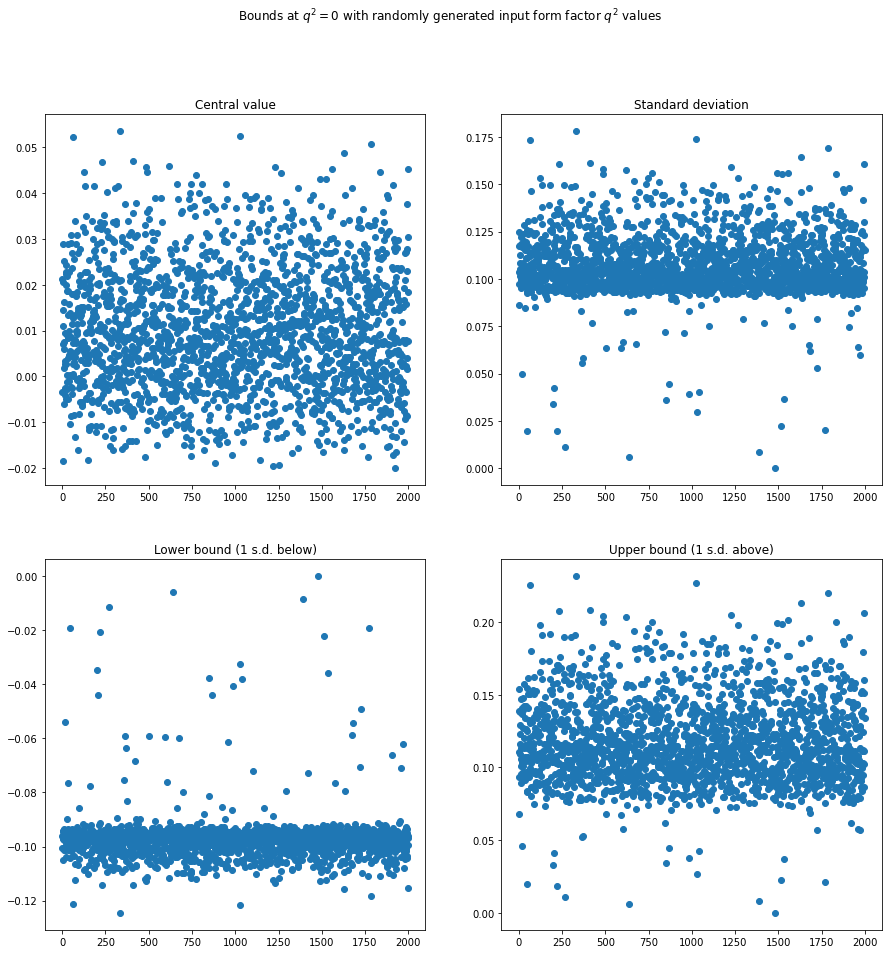

In [82]:
plt.rcParams["figure.figsize"] = (15,15)
x = range(np.shape(random_input_bounds)[1])
fig,axs = plt.subplots(2,2)
fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values')
axs[0,0].scatter(x,[random_input_bounds[0,i] for i in x])
axs[0,0].set_title("Central value")
axs[0,1].scatter(x,[random_input_bounds[1,i] for i in x])
axs[0,1].set_title("Standard deviation")
axs[1,0].scatter(x,[random_input_bounds[0,i] - random_input_bounds[1,i] for i in x])
axs[1,0].set_title("Lower bound (1 s.d. below)")
axs[1,1].scatter(x,[random_input_bounds[0,i] + random_input_bounds[1,i] for i in x])
axs[1,1].set_title("Upper bound (1 s.d. above)")

plt.show()

In [100]:
columns_to_delete = []
filterval = 0.2
for i in range(len(randfzero[0])):
    to_bin = False
    if abs(randfzero[1,i] - randfzero[0,i]) < filterval:
        to_bin = True
    if abs(randfzero[2,i] - randfzero[1,i]) < filterval:
        to_bin = True
    if abs(randfzero[2,i] - randfzero[0,i]) < filterval:
        to_bin = True
    if abs(randfplus[1,i] - randfplus[0,i]) < filterval:
        to_bin = True
    if to_bin:
        columns_to_delete.append(i)
#print(len(columns_to_delete))
random_input_bounds_filtered = np.delete(random_input_bounds,columns_to_delete,1)
randfzero_filtered = np.delete(randfzero,columns_to_delete,1)
randfplus_filtered = np.delete(randfplus,columns_to_delete,1)

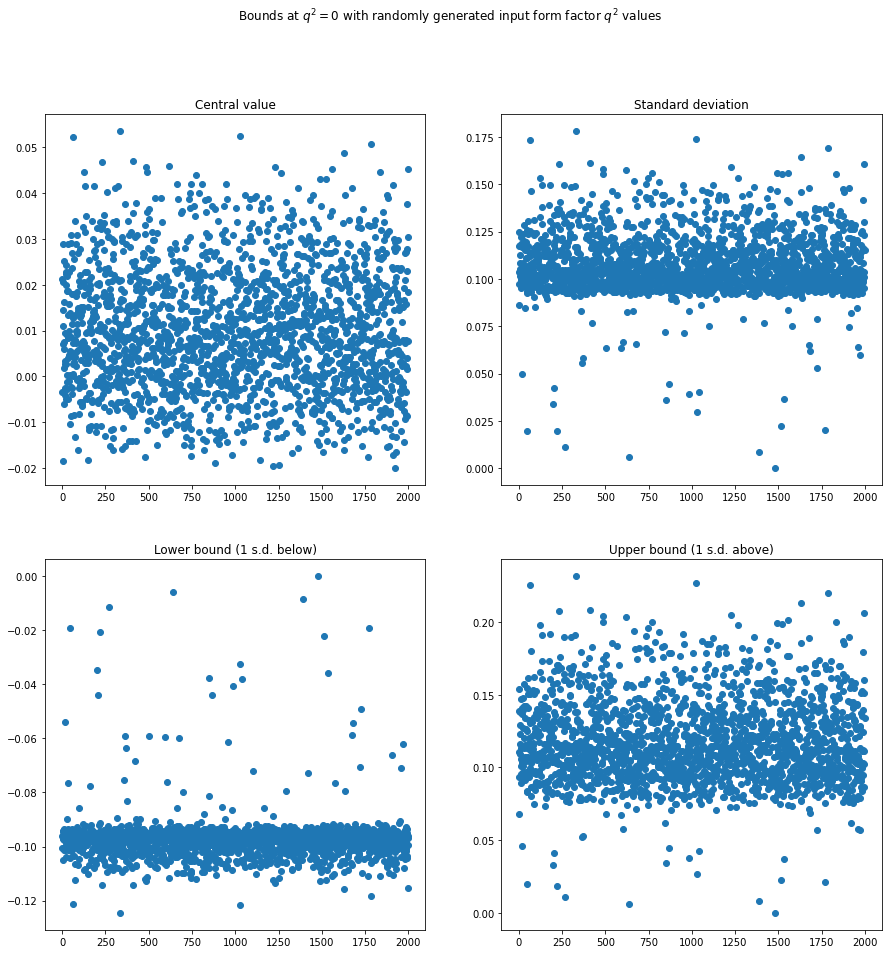

In [101]:
plt.rcParams["figure.figsize"] = (15,15)
x = range(np.shape(random_input_bounds)[1])
fig,axs = plt.subplots(2,2)
fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values')
axs[0,0].scatter(x,[random_input_bounds[0,i] for i in x])
axs[0,0].set_title("Central value")
axs[0,1].scatter(x,[random_input_bounds[1,i] for i in x])
axs[0,1].set_title("Standard deviation")
axs[1,0].scatter(x,[random_input_bounds[0,i] - random_input_bounds[1,i] for i in x])
axs[1,0].set_title("Lower bound (1 s.d. below)")
axs[1,1].scatter(x,[random_input_bounds[0,i] + random_input_bounds[1,i] for i in x])
axs[1,1].set_title("Upper bound (1 s.d. above)")

plt.show()

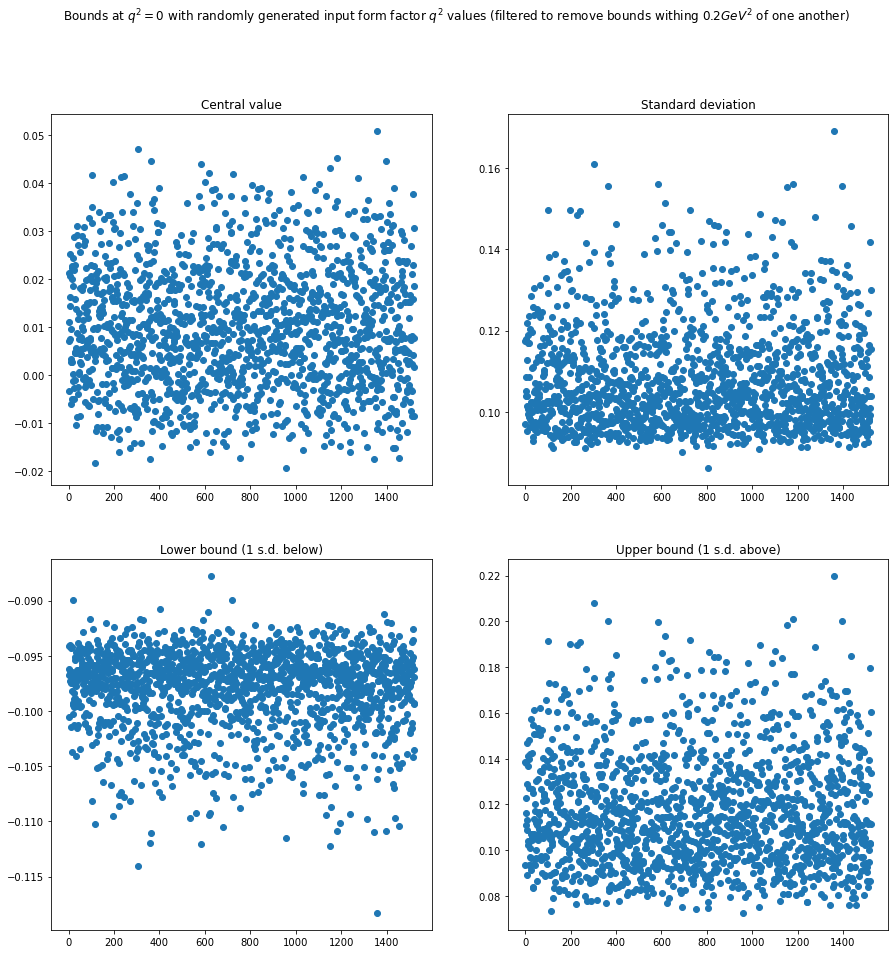

In [102]:
plt.rcParams["figure.figsize"] = (15,15)
x = range(np.shape(random_input_bounds_filtered)[1])
fig,axs = plt.subplots(2,2)
fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values (filtered to remove bounds withing $0.2 GeV^2$ of one another)')
axs[0,0].scatter(x,[random_input_bounds_filtered[0,i] for i in x])
axs[0,0].set_title("Central value")
axs[0,1].scatter(x,[random_input_bounds_filtered[1,i] for i in x])
axs[0,1].set_title("Standard deviation")
axs[1,0].scatter(x,[random_input_bounds_filtered[0,i] - random_input_bounds_filtered[1,i] for i in x])
axs[1,0].set_title("Lower bound (1 s.d. below)")
axs[1,1].scatter(x,[random_input_bounds_filtered[0,i] + random_input_bounds_filtered[1,i] for i in x])
axs[1,1].set_title("Upper bound (1 s.d. above)")

plt.show()

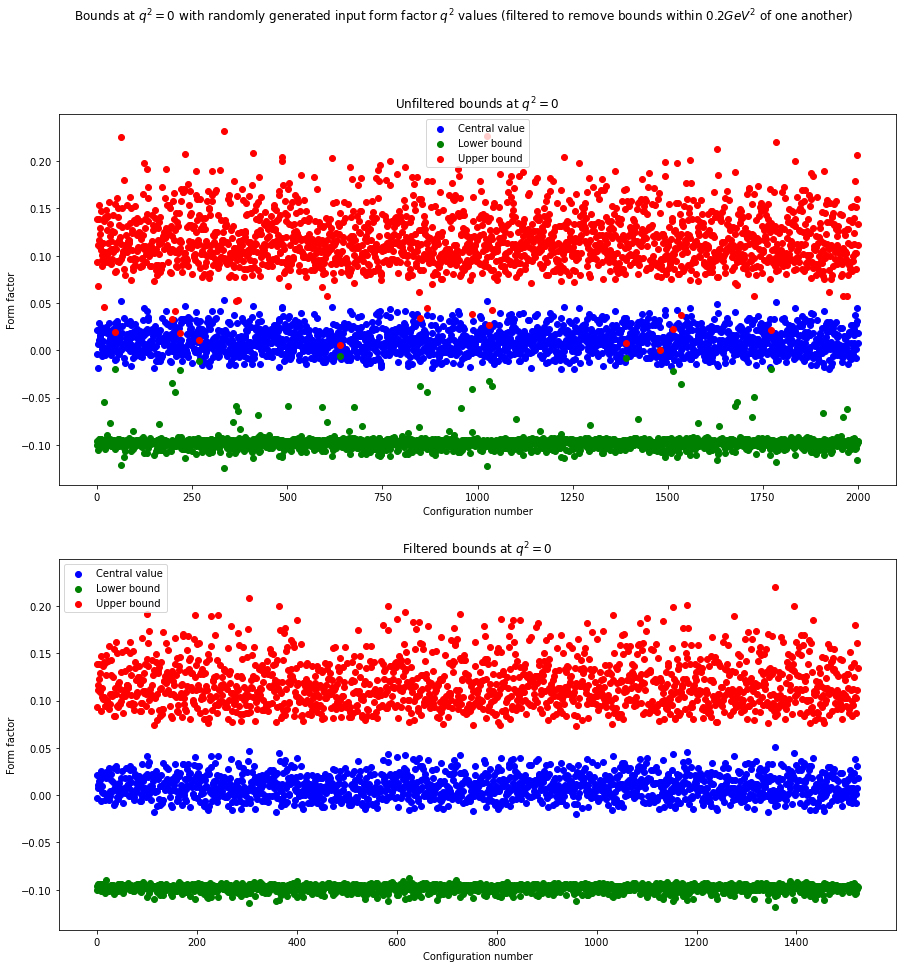

In [113]:
plt.rcParams["figure.figsize"] = (15,15)
x = range(np.shape(random_input_bounds)[1])
y = range(np.shape(random_input_bounds_filtered)[1])

fig,axs = plt.subplots(2,1,sharey=True)
fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values (filtered to remove bounds within $0.2 GeV^2$ of one another)')
axs[0].set_title("Unfiltered bounds at $q^2 = 0$")
axs[0].scatter(x,[random_input_bounds[0,i] for i in x],color = "blue",label="Central value")
axs[0].scatter(x,[random_input_bounds[0,i] - random_input_bounds[1,i] for i in x],color = "green",label="Lower bound")
axs[0].scatter(x,[random_input_bounds[0,i] + random_input_bounds[1,i] for i in x],color = "red",label="Upper bound")
axs[1].set_title("Filtered bounds at $q^2 = 0$")
axs[1].scatter(y,[random_input_bounds_filtered[0,i] for i in y],color = "blue",label="Central value")
axs[1].scatter(y,[random_input_bounds_filtered[0,i] - random_input_bounds_filtered[1,i] for i in y],color = "green",label="Lower bound")
axs[1].scatter(y,[random_input_bounds_filtered[0,i] + random_input_bounds_filtered[1,i] for i in y],color = "red",label="Upper bound")
axs[0].legend()
axs[0].set_ylabel(r'Form factor')
axs[0].set_xlabel(r'Configuration number')
axs[1].legend()
axs[1].set_ylabel(r'Form factor')
axs[1].set_xlabel(r'Configuration number')

plt.show()

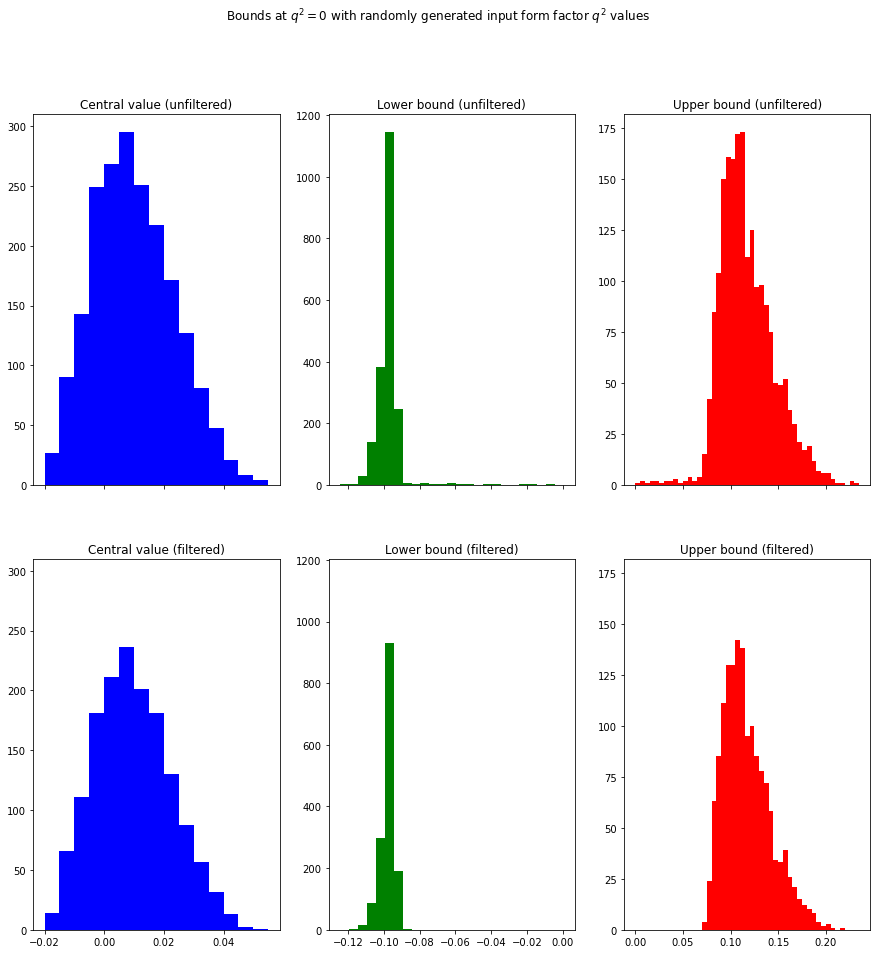

In [104]:
plt.rcParams["figure.figsize"] = (15,15)
x = range(np.shape(random_input_bounds)[1])
y = range(np.shape(random_input_bounds_filtered)[1])
binwidth = 0.005 
fig,axs = plt.subplots(2,3,sharex='col',sharey='col')
fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values')
axs[0,0].set_title("Central value (unfiltered)")
axs[0,0].hist([random_input_bounds[0,i] for i in x],color = "blue",bins=np.arange(min(random_input_bounds[0,:]), max(random_input_bounds[0,:]) + binwidth, binwidth))
lbdata = random_input_bounds[0,:] - random_input_bounds[1,:]
axs[0,1].set_title("Lower bound (unfiltered)")
axs[0,1].hist([random_input_bounds[0,i] - random_input_bounds[1,i] for i in x],color = "green",bins=np.arange(min(lbdata), max(lbdata) + binwidth, binwidth))
ubdata = random_input_bounds[0,:] + random_input_bounds[1,:]
axs[0,2].set_title("Upper bound (unfiltered)")
axs[0,2].hist([random_input_bounds[0,i] + random_input_bounds[1,i] for i in x],color = "red",bins=np.arange(min(ubdata), max(ubdata) + binwidth, binwidth))

axs[1,0].set_title("Central value (filtered)")
axs[1,0].hist([random_input_bounds_filtered[0,i] for i in y],color = "blue",bins=np.arange(min(random_input_bounds[0,:]), max(random_input_bounds[0,:]) + binwidth, binwidth))
axs[1,1].set_title("Lower bound (filtered)")
axs[1,1].hist([random_input_bounds_filtered[0,i] - random_input_bounds_filtered[1,i] for i in y],color = "green",bins=np.arange(min(lbdata), max(lbdata) + binwidth, binwidth))
axs[1,2].set_title("Upper bound (filtered)")
axs[1,2].hist([random_input_bounds_filtered[0,i] + random_input_bounds_filtered[1,i] for i in y],color = "red",bins=np.arange(min(ubdata), max(ubdata) + binwidth, binwidth))



plt.show()

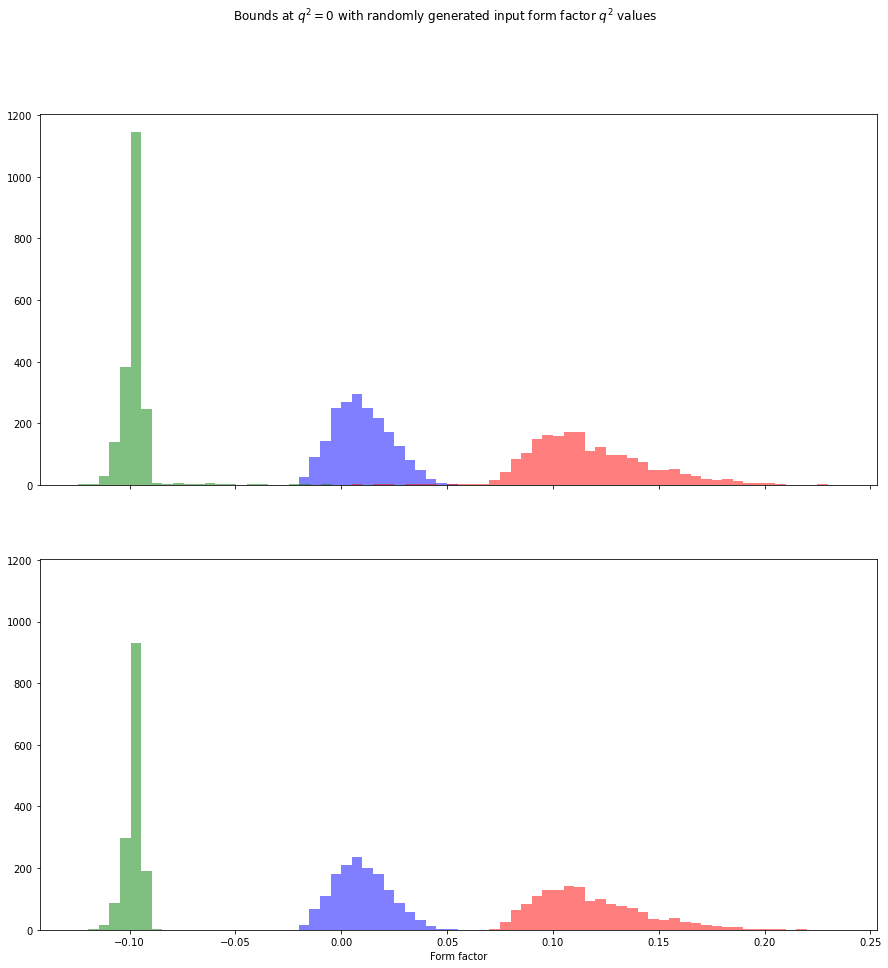

In [110]:
plt.rcParams["figure.figsize"] = (15,15)
x = range(np.shape(random_input_bounds)[1])
y = range(np.shape(random_input_bounds_filtered)[1])
binwidth = 0.005 
fig,axs = plt.subplots(2,1,sharex='col',sharey='col')
fig.suptitle(r'Bounds at $q^2 = 0$ with randomly generated input form factor $q^2$ values')
axs[0].hist([random_input_bounds[0,i] for i in x],color = "blue",bins=np.arange(min(random_input_bounds[0,:]), max(random_input_bounds[0,:]) + binwidth, binwidth),alpha=0.5)
lbdata = random_input_bounds[0,:] - random_input_bounds[1,:]
axs[0].hist([random_input_bounds[0,i] - random_input_bounds[1,i] for i in x],color = "green",bins=np.arange(min(lbdata), max(lbdata) + binwidth, binwidth),alpha=0.5)
ubdata = random_input_bounds[0,:] + random_input_bounds[1,:]
axs[0].hist([random_input_bounds[0,i] + random_input_bounds[1,i] for i in x],color = "red",bins=np.arange(min(ubdata), max(ubdata) + binwidth, binwidth),alpha=0.5)

axs[1].hist([random_input_bounds_filtered[0,i] for i in y],color = "blue",bins=np.arange(min(random_input_bounds[0,:]), max(random_input_bounds[0,:]) + binwidth, binwidth),alpha=0.5)
axs[1].hist([random_input_bounds_filtered[0,i] - random_input_bounds_filtered[1,i] for i in y],color = "green",bins=np.arange(min(lbdata), max(lbdata) + binwidth, binwidth),alpha=0.5)
axs[1].hist([random_input_bounds_filtered[0,i] + random_input_bounds_filtered[1,i] for i in y],color = "red",bins=np.arange(min(ubdata), max(ubdata) + binwidth, binwidth),alpha=0.5)
axs[1].set_xlabel(r'Form factor')

plt.show()

In [106]:
### investigating covariance between lowest f0 point and bound values ###

fzero_fs = np.sort(randfzero_filtered,axis=0)
fzero_fs_smallestinputmean = np.mean(fzero_fs[0,:])
fplus_fs = np.sort(randfplus_filtered,axis=0)

lowerbounds = random_input_bounds_filtered[0,:] - random_input_bounds_filtered[1,:]
avg_lowerbound = np.mean(lowerbounds)
centralvals = random_input_bounds_filtered[0,:]
avg_centralval = np.mean(centralvals)
upperbounds = random_input_bounds_filtered[0,:] + random_input_bounds_filtered[1,:]
avg_upperbound = np.mean(upperbounds)

In [107]:
i = 201
for i in range(len(random_input_bounds_filtered[0,:])):
    if random_input_bounds_filtered[0,i] - random_input_bounds_filtered[1,i] >-.08:
        print(i,fzero_fs[:,i],fplus_fs[:,i])

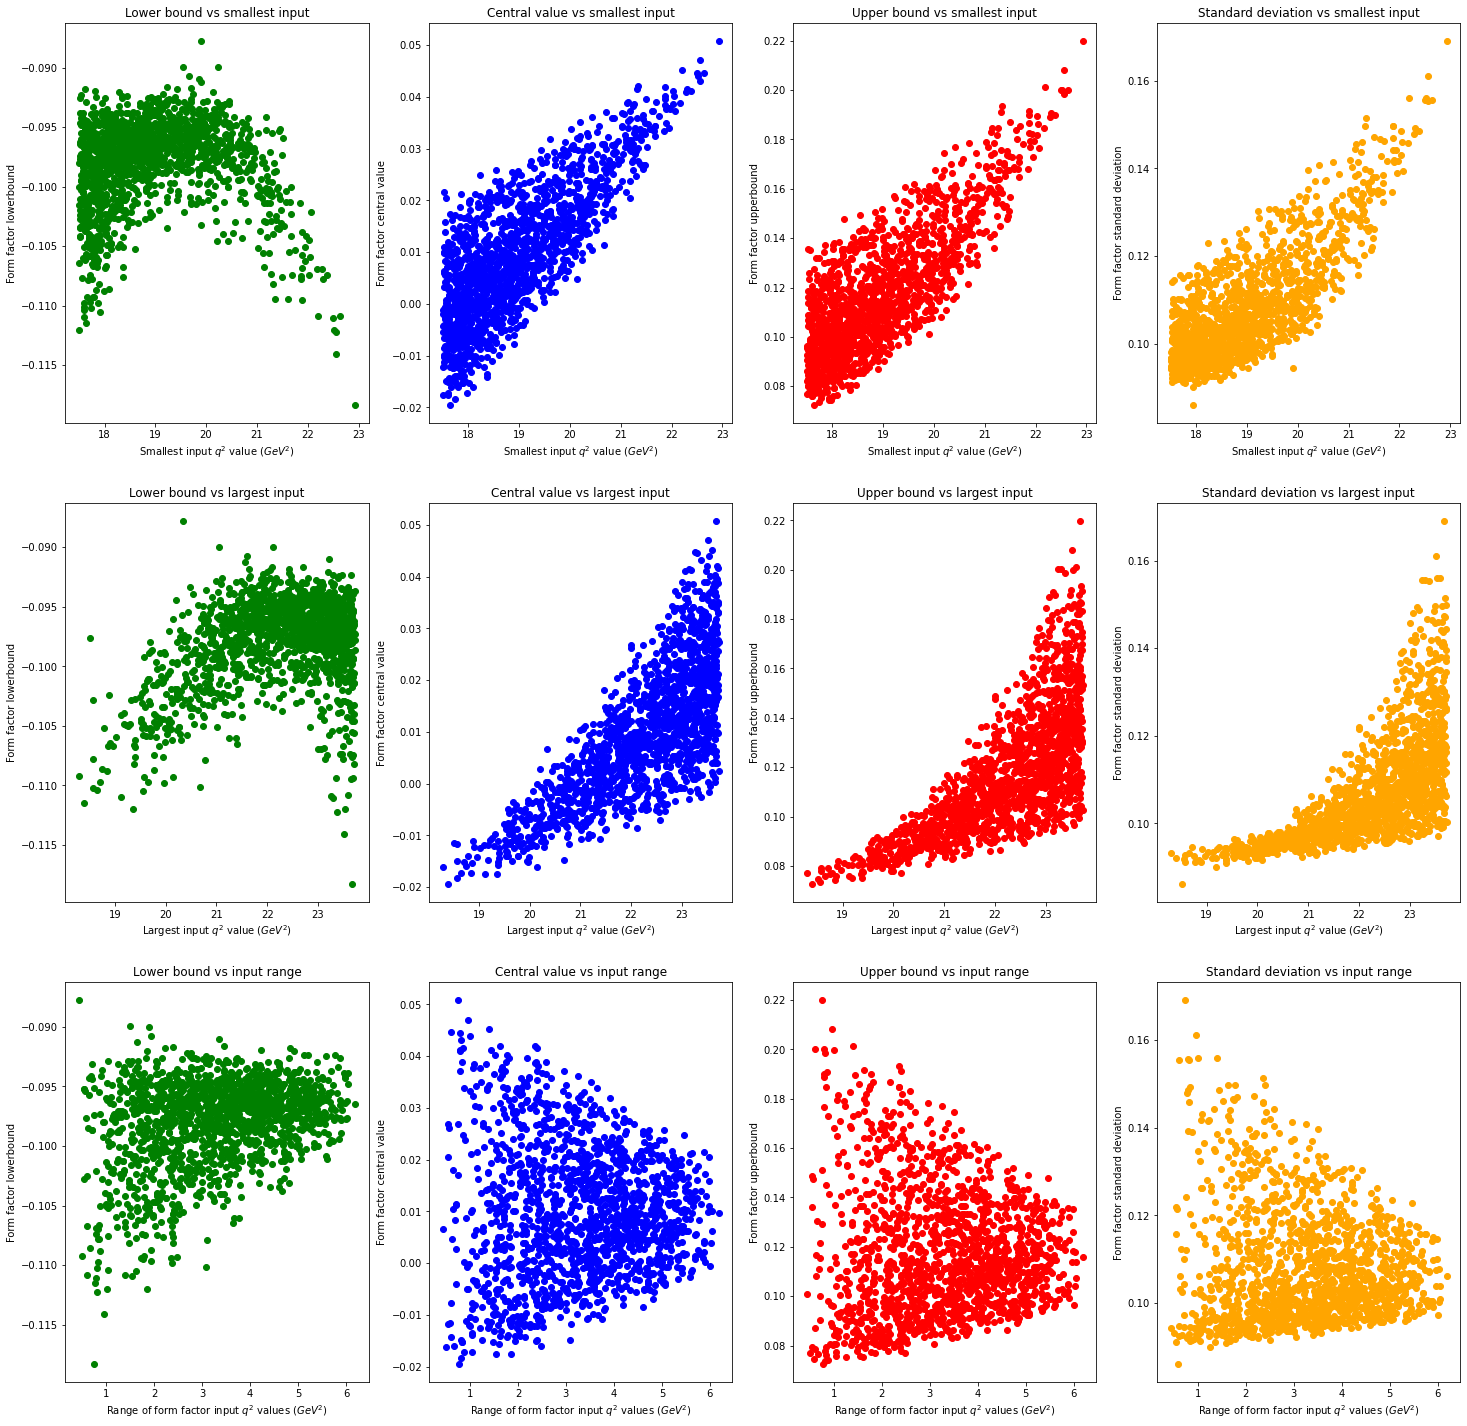

In [109]:
plt.rcParams["figure.figsize"] = (25,25)
plotrange = range(np.shape(fzero_fs)[1])
fig,axs = plt.subplots(3,4)#,sharex='col',sharey='col'
#fig.suptitle(r"Investigating how bounds change with the input form factor values (filtered)")
axs[0,0].set_title("Lower bound vs smallest input")
axs[0,0].scatter([fzero_fs[0,i] for i in plotrange],[lowerbounds[i] for i in plotrange],color = "green")#,label="Central value"
axs[0,0].set_xlabel(r'Smallest input $q^2$ value ($GeV^2$)')
axs[0,0].set_ylabel(r'Form factor lowerbound')

axs[0,1].set_title("Central value vs smallest input")
axs[0,1].scatter([fzero_fs[0,i] for i in plotrange],[centralvals[i] for i in plotrange],color = "blue")#,label="Central value"
axs[0,1].set_xlabel(r'Smallest input $q^2$ value ($GeV^2$)')
axs[0,1].set_ylabel(r'Form factor central value')

axs[0,2].set_title("Upper bound vs smallest input")
axs[0,2].scatter([fzero_fs[0,i] for i in plotrange],[upperbounds[i] for i in plotrange],color = "red")#,label="Central value"
axs[0,2].set_xlabel(r'Smallest input $q^2$ value ($GeV^2$)')
axs[0,2].set_ylabel(r'Form factor upperbound')

axs[0,3].set_title("Standard deviation vs smallest input")
axs[0,3].scatter([fzero_fs[0,i] for i in plotrange],[upperbounds[i]-centralvals[i] for i in plotrange],color = "orange")#,label="Central value"
axs[0,3].set_xlabel(r'Smallest input $q^2$ value ($GeV^2$)')
axs[0,3].set_ylabel(r'Form factor standard deviation')

axs[1,0].set_title("Lower bound vs largest input")
axs[1,0].scatter([fzero_fs[2,i] for i in plotrange],[lowerbounds[i] for i in plotrange],color = "green")#,label="Central value"
axs[1,0].set_xlabel(r'Largest input $q^2$ value ($GeV^2$)')
axs[1,0].set_ylabel(r'Form factor lowerbound')

axs[1,1].set_title("Central value vs largest input")
axs[1,1].scatter([fzero_fs[2,i] for i in plotrange],[centralvals[i] for i in plotrange],color = "blue")#,label="Central value"
axs[1,1].set_xlabel(r'Largest input $q^2$ value ($GeV^2$)')
axs[1,1].set_ylabel(r'Form factor central value')

axs[1,2].set_title("Upper bound vs largest input")
axs[1,2].scatter([fzero_fs[2,i] for i in plotrange],[upperbounds[i] for i in plotrange],color = "red")#,label="Central value"
axs[1,2].set_xlabel(r'Largest input $q^2$ value ($GeV^2$)')
axs[1,2].set_ylabel(r'Form factor upperbound')

axs[1,3].set_title("Standard deviation vs largest input")
axs[1,3].scatter([fzero_fs[2,i] for i in plotrange],[upperbounds[i]-centralvals[i] for i in plotrange],color = "orange")#,label="Central value"
axs[1,3].set_xlabel(r'Largest input $q^2$ value ($GeV^2$)')
axs[1,3].set_ylabel(r'Form factor standard deviation')

axs[2,0].set_title("Lower bound vs input range")
axs[2,0].scatter([fzero_fs[2,i]-fzero_fs[0,i] for i in plotrange],[lowerbounds[i] for i in plotrange],color = "green")#,label="Central value"
axs[2,0].set_xlabel(r'Range of form factor input $q^2$ values ($GeV^2$)')
axs[2,0].set_ylabel(r'Form factor lowerbound')

axs[2,1].set_title("Central value vs input range")
axs[2,1].scatter([fzero_fs[2,i]-fzero_fs[0,i] for i in plotrange],[centralvals[i] for i in plotrange],color = "blue")#,label="Central value"
axs[2,1].set_xlabel(r'Range of form factor input $q^2$ values ($GeV^2$)')
axs[2,1].set_ylabel(r'Form factor central value')

axs[2,2].set_title("Upper bound vs input range")
axs[2,2].scatter([fzero_fs[2,i]-fzero_fs[0,i] for i in plotrange],[upperbounds[i] for i in plotrange],color = "red")#,label="Central value"
axs[2,2].set_xlabel(r'Range of form factor input $q^2$ values ($GeV^2$)')
axs[2,2].set_ylabel(r'Form factor upperbound')

axs[2,3].set_title("Standard deviation vs input range")
axs[2,3].scatter([fzero_fs[2,i]-fzero_fs[0,i] for i in plotrange],[upperbounds[i]-centralvals[i] for i in plotrange],color = "orange")#,label="Central value"
axs[2,3].set_xlabel(r'Range of form factor input $q^2$ values ($GeV^2$)')
axs[2,3].set_ylabel(r'Form factor standard deviation')

plt.show()

###### plt.rcParams["figure.figsize"] = (15,15)
plustlist = [17,18,23]
zerotlist = [17,23]
MILCq2list = [17.5,18.5,22.5]
q2list = np.linspace(0,23,24)
milcresample = np.array(milc.resample_ff(q2list,2000))
nmb_milc = np.array(bounds_from_MILC(MILCq2list,nboot=2000,toutl=q2list))

#print(np.shape(nmb))
plt.fill_between(q2list,[nmb_milc[index,2]-nmb_milc[index,4] for index,q2 in enumerate(q2list)],[nmb_milc[index,2]+nmb_milc[index,4] for index,q2 in enumerate(q2list)],linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.fill_between(q2list,[nmb_milc[index,1]-nmb_milc[index,3] for index,q2 in enumerate(q2list)],[nmb_milc[index,1]+nmb_milc[index,3] for index,q2 in enumerate(q2list)],linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.errorbar(MILCq2list, [milc.fzero_from_q2(q2) for q2 in MILCq2list], yerr=[np.std(milcresample[0,index]) for index,q2 in enumerate(MILCq2list)],xerr=None, fmt='o',capsize=4,color = "blue",label = "f0 from MILC data")
plt.errorbar(MILCq2list, [milc.fplus_from_q2(q2) for q2 in MILCq2list], yerr=[np.std(milcresample[1,index]) for index,q2 in enumerate(MILCq2list)],xerr=None, fmt='o',capsize=4,color = "blue",label = "f+ from MILC data")
plt.errorbar(zerotlist, bskpts[-nzero:], yerr = [bskcov[-nzero:,-nzero:][i,i]**0.5 for i in range(nzero)],xerr=None, fmt='o',capsize=4,color = "green", label = "f+ from our data")
plt.errorbar(plustlist, bskpts[:nplus], yerr = [bskcov[:nplus,:nplus][i,i]**0.5 for i in range(nplus)],xerr=None, fmt='o',capsize=4,color = "green", label = "f0 from our data")
nmb = np.array(bounds_from_input_q2([17,23],[17,18,23],nboot=2000,toutl=q2list))
plt.fill_between(q2list,[nmb[index,2]-nmb[index,4] for index,q2 in enumerate(q2list)],[nmb[index,2]+nmb[index,4] for index,q2 in enumerate(q2list)],linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")
plt.fill_between(q2list,[nmb[index,1]-nmb[index,3] for index,q2 in enumerate(q2list)],[nmb[index,1]+nmb[index,3] for index,q2 in enumerate(q2list)],linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")


plt.legend()
plt.show()